In [6]:
!pip install opencv-python

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import keras
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D
from keras.layers import  Dropout, Activation
from keras.optimizers import Adam, SGD
from keras.layers import LeakyReLU
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import backend as K
from keras.utils import plot_model
import tensorflow as tf
import glob
import random
import cv2
from random import shuffle

# Generators

import os
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

!mkdir -p drive -v

cwd = os.getcwd()

monchemin = 'gdrive/My Drive/CV_projet/'

dir_path=os.path.join(cwd, monchemin)
dirs =os.listdir(dir_path)
print(dir_path)
print (dirs)

os.chdir(dir_path)

!export PYTHONPATH=$PYTHONPATH:dir_path

In [13]:
monchemin = 'C:/Users/basti/OneDrive/Documents/COURS/3A/IAM-3/computer_vision/'
os.chdir(monchemin)

In [3]:
%cd CV_projet
%ls

[WinError 2] Le fichier spécifié est introuvable: 'CV_projet'
C:\Users\basti\OneDrive\Documents\COURS\3A\IAM-3\computer_vision
 Le volume dans le lecteur C s’appelle OS
 Le numéro de série du volume est FA27-6DC7

 Répertoire de C:\Users\basti\OneDrive\Documents\COURS\3A\IAM-3\computer_vision

17/03/2023  09:48    <DIR>          .
10/03/2023  09:16    <DIR>          ..
17/03/2023  09:48    <DIR>          .ipynb_checkpoints
10/03/2023  11:07               162 commandes linux (commandes).txt
17/03/2023  09:47            37 612 Copie_de_Copie_de_Copy_of_Unet.ipynb
10/03/2023  09:15             8 737 CV_TP3_23_students_classif.ipynb
10/03/2023  10:18        18 567 041 etat_de_l'art_ml_image_classification.pdf
10/03/2023  09:14         8 569 356 etatdel'art_detection_image.pdf
10/03/2023  13:55         6 012 017 interp23.pdf
10/03/2023  13:54        65 403 237 main_CV4_21_short.pdf
10/03/2023  09:14        25 568 751 main_intro.pdf
10/03/2023  09:16    <DIR>          miniMIT_Etus
10/03/2023

In [8]:
import re

In [18]:
def image_generator(files, batch_size = 32, sz = (256, 256)):
  
  while True: 
    
    #extract a random batch 
    batch = np.random.choice(files, size = batch_size)    
    
    #variables for collecting batches of inputs and outputs 
    batch_x = []
    batch_y = []
    
    
    for f in batch:
        #get the masks. Note that masks are png files 
        if re.search(r'munster', f):
            mask = Image.open(f'gtFine_trainvaltest/gtFine/val/munster/{f[:21]}_gtFine_color.png')
            mask = np.array(mask.resize(sz))
        if re.search(r'lindau', f):
            mask = Image.open(f'gtFine_trainvaltest/gtFine/val/lindau/{f[:20]}_gtFine_color.png')
            mask = np.array(mask.resize(sz))
        if re.search(r'frankfurt', f):
            mask = Image.open(f'gtFine_trainvaltest/gtFine/val/frankfurt/{f[:23]}_gtFine_color.png')
            mask = np.array(mask.resize(sz))

        #preprocess the mask
        
        batch_y.append(mask)

        #preprocess the raw images 
        if re.search(r'munster', f):
            raw = Image.open(f'leftImg8bit_trainvaltest/leftImg8bit/val/munster/{f}')
        if re.search(r'lindau', f):
            raw = Image.open(f'leftImg8bit_trainvaltest/leftImg8bit/val/lindau/{f}')
        if re.search(r'frankfurt', f):
            raw = Image.open(f'leftImg8bit_trainvaltest/leftImg8bit/val/frankfurt/{f}')

        raw = raw.resize(sz)
        raw = np.array(raw)

        #check the number of channels because some of the images are RGBA or GRAY
        if len(raw.shape) == 2:
          raw = np.stack((raw,)*3, axis=-1)

        else:
          raw = raw[:,:,0:3]

        batch_x.append(raw)

    #preprocess a batch of images and masks 
    batch_x = np.array(batch_x)/255.
    batch_y = np.array(batch_y)
    batch_y = np.expand_dims((batch_y, 1), 1)

    yield (batch_x, batch_y)      
    

In [19]:
batch_size = 32
nb_class = 19 #D'après la doc que j'ai lu il y a 19 classes pour ce dataset;

train_files = os.listdir('leftImg8bit_trainvaltest/leftImg8bit/val/frankfurt')
val_files = os.listdir('leftImg8bit_trainvaltest/leftImg8bit/val/munster')
test_files = os.listdir('leftImg8bit_trainvaltest/leftImg8bit/val/lindau')


train_generator = image_generator(train_files, batch_size = batch_size)
val_generator = image_generator(val_files, batch_size = batch_size)
test_generator  = image_generator(test_files, batch_size = batch_size)

In [20]:
import sys

In [21]:
x, y= next(train_generator)

C:\Users\basti\anaconda3\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


In [22]:
sys.getsizeof(x)

50331800

In [23]:
x.shape

(32, 256, 256, 3)

In [24]:
print(y.shape)
y[0][0].shape

(2, 1)


(32, 256, 256, 4)

In [25]:
y[1][0]

1

In [26]:
import matplotlib.pyplot as plt 

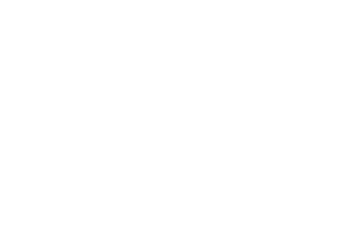

In [27]:
plt.axis('off')
img = x[0]
msk = y[0].squeeze()
msk = np.stack((msk,)*3, axis=-1)

In [34]:
msk[2]==msk[1]

array([[[[ True,  True,  True,  True],
         [ True,  True,  True,  True],
         [ True,  True,  True,  True],
         ...,
         [ True,  True,  True,  True],
         [ True,  True,  True,  True],
         [ True,  True,  True,  True]],

        [[ True,  True,  True,  True],
         [ True,  True,  True,  True],
         [ True,  True,  True,  True],
         ...,
         [ True,  True,  True,  True],
         [ True,  True,  True,  True],
         [ True,  True,  True,  True]],

        [[ True,  True,  True,  True],
         [ True,  True,  True,  True],
         [ True,  True,  True,  True],
         ...,
         [ True,  True,  True,  True],
         [ True,  True,  True,  True],
         [ True,  True,  True,  True]],

        ...,

        [[ True,  True,  True,  True],
         [ True,  True,  True,  True],
         [ True,  True,  True,  True],
         ...,
         [ True,  True,  True,  True],
         [ True,  True,  True,  True],
         [ True,  True,  Tr

In [ ]:
 np.concatenate([img, msk], axis = 1)

ValueError: ignored

MemoryError: Unable to allocate 64.0 MiB for an array with shape (32, 256, 256, 4) and data type float64

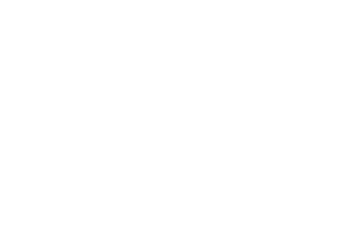

In [29]:
plt.axis('off')
img = x[0]
msk = y[0].squeeze()
msk = np.stack((msk,)*3, axis=-1)

plt.imshow( np.concatenate([img, msk, img*msk], axis = 1))

# IoU metric

The intersection over union (IoU) metric is a simple metric used to evaluate the performance of a segmentation algorithm. Given two masks $y_{true}, y_{pred}$ we evaluate 

$$IoU = \frac{y_{true} \cap y_{pred}}{y_{true} \cup y_{pred}}$$

In [ ]:
def mean_iou(y_true, y_pred):
    yt0 = y_true[:,:,:,0]
    yp0 = K.cast(y_pred[:,:,:,0] > 0.5, 'float32')
    inter = tf.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
    union = tf.count_nonzero(tf.add(yt0, yp0))
    iou = tf.where(tf.equal(union, 0), 1., tf.cast(inter/union, 'float32'))
    return iou

# Model

In [ ]:
def unet(sz = (256, 256, 3)):
  x = Input(sz)
  inputs = x
  
  #down sampling 
  f = 8
  layers = []
  
  for i in range(0, 6):
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    layers.append(x)
    x = MaxPooling2D() (x)
    f = f*2
  ff2 = 64 
  
  #bottleneck 
  j = len(layers) - 1
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
  x = Concatenate(axis=3)([x, layers[j]])
  j = j -1 
  
  #upsampling 
  for i in range(0, 5):
    ff2 = ff2//2
    f = f // 2 
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
    x = Concatenate(axis=3)([x, layers[j]])
    j = j -1 
    
  
  #classification 
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  outputs = Conv2D(nb_class, 1, 1, activation='softmax') (x)
  
  #model creation 
  model = Model(inputs=[inputs], outputs=[outputs])
  model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = [mean_iou])
  
  return model

In [ ]:
model = unet()

# Callbacks

Simple functions to save the model at each epoch and show some predictions 

In [ ]:
def build_callbacks():
        checkpointer = ModelCheckpoint(filepath='unet.h5', verbose=0, save_best_only=True, save_weights_only=True)
        callbacks = [checkpointer, PlotLearning()]
        return callbacks

# inheritance for training process plot 
class PlotLearning(keras.callbacks.Callback):

    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        #self.fig = plt.figure()
        self.logs = []
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('mean_iou'))
        self.val_acc.append(logs.get('val_mean_iou'))
        self.i += 1
        print('i=',self.i,'loss=',logs.get('loss'),'val_loss=',logs.get('val_loss'),'mean_iou=',logs.get('mean_iou'),'val_mean_iou=',logs.get('val_mean_iou'))
        
        #choose a random test image and preprocess
        path = np.random.choice(test_files)
        raw = Image.open(f'images/{path}')
        raw = np.array(raw.resize((256, 256)))/255.
        raw = raw[:,:,0:3]
        
        #predict the mask 
        pred = model.predict(np.expand_dims(raw, 0))
        
        #mask post-processing 
        msk  = pred.squeeze()
        msk = np.stack((msk,)*3, axis=-1)
        msk[msk >= 0.5] = 1 
        msk[msk < 0.5] = 0 
        
        #show the mask and the segmented image 
        combined = np.concatenate([raw, msk, raw* msk], axis = 1)
        plt.axis('off')
        plt.imshow(combined)
        plt.show()

# Training

In [ ]:
train_steps = len(train_files) //batch_size
val_steps = len(val_files) //batch_size
model.fit_generator(train_generator, 
                    epochs = 30, steps_per_epoch = train_steps,validation_data = val_generator, validation_steps = val_steps,
                    callbacks = build_callbacks(), verbose = 0)

# Testing

In [ ]:
model.evaluate_generator(test_generator)